# Marketing Campaign Analysis



In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
#!pip install -U seaborn

In [2]:
df = pd.read_csv('../data/marketing_campaign.csv',sep =';')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

We have 3 categorical variables, and 26 numerical variables
We have 24 null values in the Income column.

In [4]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Printing the data points with null values below.

In [5]:
null_income_df = df[df['Income'].isnull()]
print(null_income_df[:10])

        ID  Year_Birth   Education Marital_Status  Income  Kidhome  Teenhome  \
10    1994        1983  Graduation        Married     NaN        1         0   
27    5255        1986  Graduation         Single     NaN        1         0   
43    7281        1959         PhD         Single     NaN        0         0   
48    7244        1951  Graduation         Single     NaN        2         1   
58    8557        1982  Graduation         Single     NaN        1         0   
71   10629        1973    2n Cycle        Married     NaN        1         0   
90    8996        1957         PhD        Married     NaN        2         1   
91    9235        1957  Graduation         Single     NaN        1         1   
92    5798        1973      Master       Together     NaN        0         0   
128   8268        1961         PhD        Married     NaN        0         1   

    Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
10   2013-11-15       11         5  ...    

# Handling missing values and Feature Engineering

We will handle missing values by approximating them with KNN. But first we will need to proceed with feature engineering so that we can handle the missing values more accurately.

In [6]:
# HasChild
df.loc[(df['Kidhome'] > 0) | (df['Teenhome'] > 0), 'HasChild'] = "Yes"
df.loc[(df['Kidhome'] == 0) & (df['Teenhome'] == 0), 'HasChild'] = "No"
df.drop(['Kidhome','Teenhome'], axis=1, inplace=True)

#Age
currentYear = datetime.now().year
df['Year_Birth'] = currentYear - df['Year_Birth']
df.rename(columns={'Year_Birth':'Age'}, inplace=True)

#Marital Status
df['Marital_Status'] = df['Marital_Status'].apply(lambda x: 'In Couple'
if x == 'Together' or x == 'Married' else 'Single')

#Educational Years
def educ_years(x):
    if x == 'Graduation':
        return 12
    elif x == 'PhD':
        return 21
    elif x == 'Master':
        return 18
    elif x == 'Basic':
        return 5
    elif x == '2n Cycle':
        return 8


df['Educational_Years'] = df['Education'].apply(educ_years)


#Spending
df['Spending'] = df['MntFishProducts'] + df['MntMeatProducts'] + df['MntFruits']\
                 + df['MntSweetProducts'] + df['MntWines'] + df['MntGoldProds']

#Seniority (number of months in company)
currentTime = datetime.now()
def seniority_func(x):
    date_format = '%Y-%m-%d'
    #convert string to date, find delta
    x = datetime.strptime(x,date_format)
    delta = currentTime - x
    return delta.days / 30.417 #Formula by Google.


df['Seniority'] = df['Dt_Customer'].apply(seniority_func)

#Drop excess columns
df.drop(['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5'
            ,'Response','Complain','Dt_Customer', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

In [7]:
df[['Age','Income','Spending','Educational_Years','Seniority']].describe()

,Age,Income,Spending,Educational_Years,Seniority
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000
mean,52.194196,52247.251354,605.798214,14.412500,94.144135
std,11.984069,25173.076661,602.249288,4.510068,6.645051
min,25.000000,1730.000000,5.000000,5.000000,82.519644
25%,44.000000,35303.000000,68.750000,12.000000,88.462044
50%,51.000000,51381.500000,396.000000,12.000000,94.207187
75%,62.000000,68522.000000,1045.500000,18.000000,99.911234
max,128.000000,666666.000000,2525.000000,21.000000,105.500214


Text(0.5, 1.0, 'Seniority boxplot')

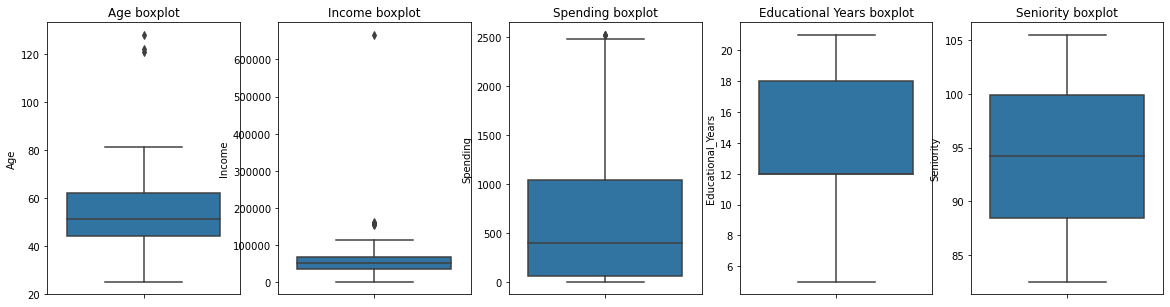

In [8]:
f, axes = plt.subplots(ncols=5, figsize=(20,5))
sns.boxplot(y="Age",data=df,ax=axes[0])
axes[0].set_title("Age boxplot")

sns.boxplot(y="Income",data=df,ax=axes[1])
axes[1].set_title("Income boxplot")

sns.boxplot(y="Spending",data=df,ax=axes[2])
axes[2].set_title("Spending boxplot")

sns.boxplot(y="Educational_Years",data=df,ax=axes[3])
axes[3].set_title("Educational Years boxplot")

sns.boxplot(y="Seniority",data=df,ax=axes[4])
axes[4].set_title("Seniority boxplot")

We will remove the extreme outlier in the income feature which is 666k. All other outliers are mild and acceptible, so there is no need for IQR.

In [9]:
df = df.drop(df[df.Income == max(df.Income)].index)

## Handling missing values
Since we found missing values in the Income feature, we will approximate them with KNN.

In [10]:
imputer = KNNImputer(n_neighbors=5,metric='nan_euclidean')
# fit on the dataset
imputer.fit(df[['Income', 'Age', 'Educational_Years', 'Spending']])
# transform the dataset
X = imputer.transform(df[['Income', 'Age', 'Educational_Years', 'Spending']])
Income_impute = pd.DataFrame(X, columns=['Income', 'Age', 'Educational_years', 'Spending'])
df['Income'] = Income_impute['Income'].reset_index(drop=True)

print(df.isnull().sum())
print(df[df['Income'] == None])
df = df.dropna()

ID                     0
Age                    0
Education              0
Marital_Status         0
Income                 1
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
HasChild               0
Educational_Years      0
Spending               0
Seniority              0
dtype: int64
Empty DataFrame
Columns: [ID, Age, Education, Marital_Status, Income, Recency, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, HasChild, Educational_Years, Spending, Seniority]
Index: []

[0 rows x 21 columns]


## Data Scaling
Standardization scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.

Normalization scales each input variable separately to the range 0-1, which is the range for floating-point values where we have the most precision.

### Should we normalize or standardize?
If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
We will use StandardScaler to normalize the data. The features we are going to normalize are Income, Age, Educational_Years, Spending, and Seniority.

### Why not both?
It may be desirable to normalize data after it has been standardized.

This might be a good idea of you have a mixture of standardized and normalized variables and wish all input variables to have the same minimum and maximum values as input for a given algorithm, such as an algorithm that calculates distance measures.

We will explore the benefits of standardizing and then normalizing the data.

![title](../standardization_vs_normalization.png)

In [11]:
#Standardization
scaler = StandardScaler()
scaled_df = df.copy()
col_names = ['Income','Spending', 'Seniority']
features = scaled_df[col_names]
scaler = scaler.fit(features.values)
features = scaler.transform(features.values)
scaled_df[col_names] = features

#Normalization
transformer = Normalizer()
col_names = ['Income','Spending', 'Seniority']
features = scaled_df[col_names]
transformer = transformer.fit(features.values)
features = transformer.transform(features.values)
scaled_df[col_names] = features

In [12]:
scaled_df[['Income','Spending','Seniority']].describe()

,Income,Spending,Seniority
count,2238.000000,2238.000000,2238.000000
mean,-0.017551,-0.078715,0.000638
std,0.550553,0.567155,0.607590
min,-0.991569,-0.998583,-0.999298
25%,-0.541238,-0.545059,-0.589558
50%,-0.022951,-0.334403,0.009035
75%,0.496327,0.511063,0.563609
max,0.986625,0.954710,0.999008


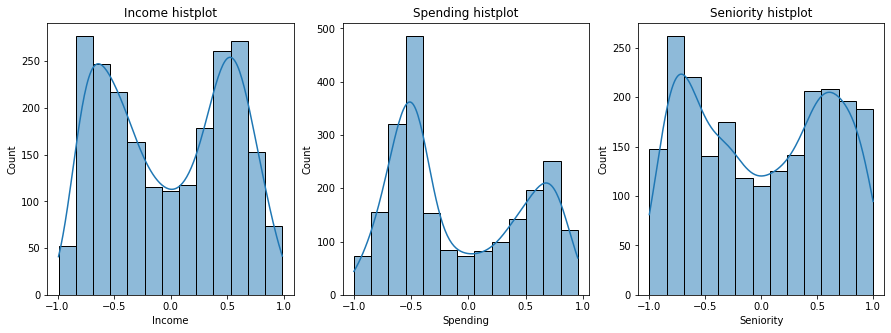

In [13]:
f, axes = plt.subplots(ncols=3, figsize=(15,5))
sns.histplot(x="Income",data=scaled_df,ax=axes[0], kde=True)
axes[0].set_title("Income histplot")

sns.histplot(x="Spending",data=scaled_df,ax=axes[1], kde=True)
axes[1].set_title("Spending histplot")

sns.histplot(x="Seniority",data=scaled_df,ax=axes[2], kde=True)
axes[2].set_title("Seniority histplot")
plt.show()

# Clustering
We will try different clustering algorithms. First we need to determine the optimal value of K for the number of clusters.

C:\Users\Filip\anaconda3\envs\MarketingCampaignAnalysis\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\Filip\anaconda3\envs\MarketingCampaignAnalysis\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


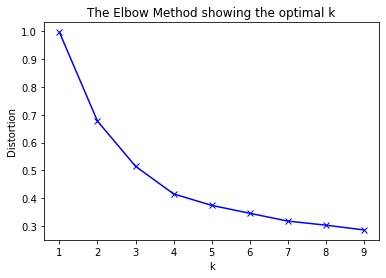

In [14]:
#Elbow method for determining the number of clusters
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(scaled_df[col_names])
    kmeanModel.fit(scaled_df[col_names])
    distortions.append(sum(np.min(cdist(scaled_df[col_names], kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / scaled_df[col_names].shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


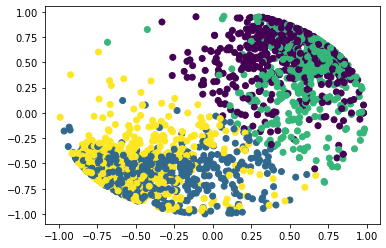

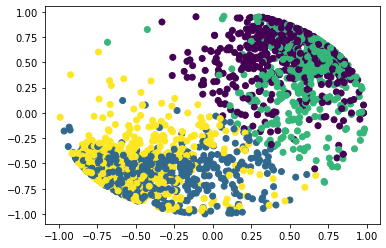

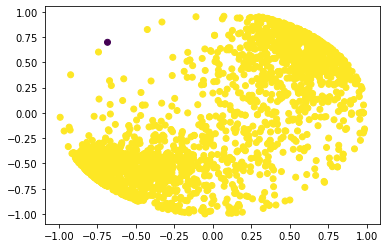

In [15]:
#KMEANS++
kmeanModel = kmeanModel = KMeans(n_clusters=4, init="k-means++", max_iter=2000, random_state=42).fit(features)
labels = kmeanModel.predict(features)
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
plt.show()

#Gaussian Mixture
gmm=GaussianMixture(n_components=4, covariance_type='spherical',max_iter=2000, random_state=42).fit(features)
labels_gmm = gmm.predict(features)
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
plt.show()

#DBSCAN
dbscan = DBSCAN(eps=0.5).fit(features)
plt.scatter(features[:, 0], features[:, 1], c=dbscan.labels_, cmap='viridis')

# Clustering Evaluation

We will use the Silhouette score to evaluate the clustering algorithms formally, though it is also evident through the cluster visualizations above that Kmeans++ and GMM have similiar, almost identical performance, and DBSCAN is performing poorly due to the variation of density in the data. The silhouette score should also reflect this observation.

We are using the cosine distance metric because in higher dimensions, euclidian distances have very little meaning since they are often very close together.

In [16]:
print('kmeans: {}'.format(silhouette_score(features, kmeanModel.labels_,
                                           metric='cosine')))

print('GMM: {}'.format(silhouette_score(features, labels_gmm,
                                           metric='cosine')))

print('DBSCAN: {}'.format(silhouette_score(features, dbscan.labels_,
                                           metric='cosine')))

kmeans: 0.6460437751502569
GMM: 0.6458197225575959
DBSCAN: 0.013202481705053568


# Cluster Interpretation

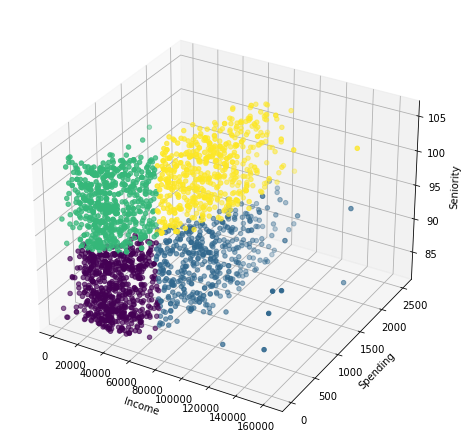

In [17]:
scaled_df['Cluster'] = labels_gmm
df['Cluster'] = labels_gmm

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

x = df['Income']
y = df['Spending']
z = df['Seniority']
c = df['Cluster']

ax.set_xlabel("Income")
ax.set_ylabel("Spending")
ax.set_zlabel("Seniority")

ax.scatter(xs=x,ys=y,zs=z,c=c)

Now that we have segmented our customers it would be nice if we would know what makes each cluster unique. This will help us understand which types of customers we have.

In [18]:
df_mean = (df.groupby('Cluster').mean())
df_mean['Count'] = df['Cluster'].value_counts()
df_mean['Percent'] = (df_mean['Count'] / df_mean['Count'].sum())*100
print(df_mean[['Income','Spending','Seniority','Count','Percent']])

def cluster_func(x):
    if x == 3:
        return 'Stars'
    elif x == 2:
        return 'Leaky bucket'
    elif x == 1:
        return 'High potential'
    elif x == 0:
        return 'Need attention'

df['Cluster'] = df['Cluster'].apply(cluster_func)

               Income     Spending   Seniority  Count    Percent
Cluster                                                         
0        38065.994470   125.546851   88.266036    651  29.088472
1        73567.007375  1084.073753   88.507490    461  20.598749
2        34550.205753   187.201354   99.618351    591  26.407507
3        69440.268037  1242.297196  100.087660    535  23.905273


- Cluster3 (**Stars**) are customers with **high** Income, Spending and Seniority. We have 535 such instances, or 23,9%
- Cluster2 (**Leaky bucket**) are customers with **low** Income and Spending, and **high** Seniority. We have 588 such instances or 26,7%
- Cluster1 (**High potential**) are customers with **high** Income and Spending, and **low** Seniority. We have 462 such instances, or 20,6%
- Cluster0 (**Need attention**) are customers with **low** Income, Spending and Seniority. We have 653 such instances, or 29,1%


As we can see, the cluster with the most customers is Cluster1 which are low income,spending and seniority.
The cluster with the least customers is Cluster2, which are high in spending and income, and low in seniority.

The stars cluster is our best marketing target, since they are our old customers who are spending a lot.
The high potential cluster is the second best marketing target, because they are spending a lot, but they are newer and require some attention.

# Association rule mining

Association rule learning is a rule-based machine learning method for discovering interesting relations between variables in large databases. Association Rules are one of the most important concepts of machine learning being used in market basket analysis.

An association rule consists of an **antecedent and consequent.** Ex. {X → Y} is a representation of finding Y on the basket which has X on it

Various metrics are in place to help us understand the strength of association between these two.

- **Support** gives an idea of how frequent an itemset is in all the transactions.
- **Confidence** gives the probability of occurrence of {Y} given {X} is present

## Apriori Algorithm
We will proceed to profile the customers, by using the apriori algorithm.
The apriori algorithm is used for association rule mining. For this we will use the mlxtend library, but first we need to bin the features.

In [19]:
q1,q3 = df['MntWines'].quantile([0.25,0.75])

def bin_func(x):
    if x == 0:
        return "Non consumer"

    if x <= q1:
        return "Low consumer"
    elif q1 < x <= q3:
        return "Frequent consumer"
    else:
        return "Biggest consumer"

df_bin = df[['Education','Marital_Status','HasChild','Cluster']]
df_bin['WineGroup'] = df['MntWines'].apply(bin_func)

q1, q3 = df['MntFruits'].quantile([0.25,0.75])
df_bin['FruitGroup'] = df['MntFruits'].apply(bin_func)

q1, q3 = df['MntMeatProducts'].quantile([0.25,0.75])
df_bin['MeatGroup'] = df['MntMeatProducts'].apply(bin_func)

q1, q3 = df['MntFishProducts'].quantile([0.25,0.75])
df_bin['FishGroup'] = df['MntFishProducts'].apply(bin_func)

q1, q3 = df['MntSweetProducts'].quantile([0.25,0.75])
df_bin['SweetGroup'] = df['MntSweetProducts'].apply(bin_func)

q1, q3 = df['MntGoldProds'].quantile([0.25,0.75])
df_bin['GoldGroup'] = df['MntGoldProds'].apply(bin_func)

def bin_senior_func(x):

    if x <= q1:
        return "New customer"
    elif q1 < x <= q3:
        return "Experienced customer"
    else:
        return "Old customer"

q1, q3 = df['Seniority'].quantile([0.25,0.75])
df_bin['SeniorityGroup'] = df['Seniority'].apply(bin_senior_func)
#df.drop(['Seniority'],axis=1,inplace=True)

def bin_income_func(x):
    if x <= q1:
        return "Low income"
    elif q1 < x <= q2:
        return "Low to medium income"
    elif q2 < x <= q3:
        return "Medium to high income"
    else:
        return "High income"

q1,q2,q3 = df['Income'].quantile([0.25,0.5,0.75])
df_bin['IncomeGroup'] = df['Income'].apply(bin_income_func)
#df.drop(['Income'],axis=1,inplace=True)

def bin_age_func(x):
    if x <= 18:
        return "Youth"
    elif 18 < x <= 35:
        return "Young adult"
    elif 35 < x <= 65:
        return "Adult"
    else:
        return "Senior"

pd.set_option('display.max_columns', None)
df_bin['AgeGroup'] = df['Age'].apply(bin_age_func)
print(df_bin.head())

    Education Marital_Status HasChild         Cluster          WineGroup  \
0  Graduation         Single       No           Stars   Biggest consumer   
1  Graduation         Single      Yes  Need attention       Low consumer   
2  Graduation      In Couple       No  High potential  Frequent consumer   
3  Graduation      In Couple      Yes  Need attention       Low consumer   
4         PhD      In Couple      Yes  Need attention  Frequent consumer   

          FruitGroup          MeatGroup          FishGroup         SweetGroup  \
0   Biggest consumer   Biggest consumer   Biggest consumer   Biggest consumer   
1       Low consumer       Low consumer       Low consumer       Low consumer   
2   Biggest consumer  Frequent consumer   Biggest consumer  Frequent consumer   
3  Frequent consumer  Frequent consumer  Frequent consumer  Frequent consumer   
4   Biggest consumer  Frequent consumer  Frequent consumer  Frequent consumer   

           GoldGroup        SeniorityGroup            In

In [20]:
df_assoc = pd.get_dummies(df_bin)

#Apriori min support
min_support = 0.08

#Max lenght of apriori n-grams
max_len = 10

frequent_items = apriori(df_assoc, use_colnames=True, min_support=min_support, max_len=max_len + 1)
rules = association_rules(frequent_items, metric='lift', min_threshold=1)

In [31]:
# We select the product and the segment we want to analyze, first we will analyze biggest wine consumers.
product='WineGroup'
segment='Biggest consumer'
target = product + "_" + segment

results_personnal_care = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 999)
print(results_personnal_care.head(5))

                                                                 antecedents  \
3251                                (Cluster_Stars, IncomeGroup_High income)   
3245                            (Cluster_Stars, SeniorityGroup_Old customer)   
3239                             (Cluster_Stars, MeatGroup_Biggest consumer)   
10722  (AgeGroup_Adult, IncomeGroup_High income, MeatGroup_Biggest consumer)   
3256                                         (Cluster_Stars, AgeGroup_Adult)   

                        consequents  antecedent support  consequent support  \
3251   (WineGroup_Biggest consumer)            0.121090            0.250223   
3245   (WineGroup_Biggest consumer)            0.124665            0.250223   
3239   (WineGroup_Biggest consumer)            0.132708            0.250223   
10722  (WineGroup_Biggest consumer)            0.124218            0.250223   
3256   (WineGroup_Biggest consumer)            0.172475            0.250223   

        support  confidence      lift  lever

## <span style="color:maroon;">Biggest consumer of wine customer profile</span>
- High income, above 68445$
- Enrolled with the company for more than 99 months
- Also a big consumer of meat products
- In the adult age group, from 35 to 65 years of age


In [33]:
product='FruitGroup'
segment='Biggest consumer'
target = product + "_" + segment

results_personnal_care = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)

print(results_personnal_care.head(5))

                                                                                 antecedents  \
11476              (SweetGroup_Biggest consumer, AgeGroup_Adult, MeatGroup_Biggest consumer)   
11422  (SweetGroup_Biggest consumer, FishGroup_Biggest consumer, MeatGroup_Biggest consumer)   
11514              (SweetGroup_Biggest consumer, FishGroup_Biggest consumer, AgeGroup_Adult)   
11500     (SweetGroup_Biggest consumer, FishGroup_Biggest consumer, IncomeGroup_High income)   
11450               (FishGroup_Biggest consumer, AgeGroup_Adult, MeatGroup_Biggest consumer)   

                         consequents  antecedent support  consequent support  \
11476  (FruitGroup_Biggest consumer)            0.108579            0.246202   
11422  (FruitGroup_Biggest consumer)            0.122878            0.246202   
11514  (FruitGroup_Biggest consumer)            0.123324            0.246202   
11500  (FruitGroup_Biggest consumer)            0.114388            0.246202   
11450  (FruitGroup_Bigg

## <span style="color:green;">Biggest consumer of fruit customer profile</span>
- Big consumer of sweets
- Big consumer of fish
- Big consumer of meat
- In the adult age group, from 35 to 65 years of age



In [32]:
product='MeatGroup'
segment='Biggest consumer'
target = product + "_" + segment

results_personnal_care = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)

print(results_personnal_care.head(5))

                                                              antecedents  \
8149   (FishGroup_Biggest consumer, IncomeGroup_High income, HasChild_No)   
8052       (IncomeGroup_High income, Cluster_High potential, HasChild_No)   
8065   (WineGroup_Biggest consumer, IncomeGroup_High income, HasChild_No)   
5939     (IncomeGroup_High income, HasChild_No, Marital_Status_In Couple)   
8108  (IncomeGroup_High income, FruitGroup_Biggest consumer, HasChild_No)   

                       consequents  antecedent support  consequent support  \
8149  (MeatGroup_Biggest consumer)            0.118856             0.24933   
8052  (MeatGroup_Biggest consumer)            0.092046             0.24933   
8065  (MeatGroup_Biggest consumer)            0.105898             0.24933   
5939  (MeatGroup_Biggest consumer)            0.106345             0.24933   
8108  (MeatGroup_Biggest consumer)            0.106345             0.24933   

       support  confidence      lift  leverage  conviction  
8149  0

## <span style="color:red;">Biggest consumer of meat customer profile</span>
- Has no children
- High income, above 68445$
- New customer, enrolled with the company for around 88 months (Cluster High Potential)
- Big consumer of fish products
- Big consumer of wine products
- Big consumer of fruit products

In [36]:
product='FishGroup'
segment='Biggest consumer'
target = product + "_" + segment

results_personnal_care = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)

print(results_personnal_care.head(8))

                                                                                  antecedents  \
8122                  (SweetGroup_Biggest consumer, FruitGroup_Biggest consumer, HasChild_No)   
11424  (SweetGroup_Biggest consumer, MeatGroup_Biggest consumer, FruitGroup_Biggest consumer)   
11502     (SweetGroup_Biggest consumer, IncomeGroup_High income, FruitGroup_Biggest consumer)   
8081                   (MeatGroup_Biggest consumer, FruitGroup_Biggest consumer, HasChild_No)   
8136                   (SweetGroup_Biggest consumer, MeatGroup_Biggest consumer, HasChild_No)   
11877               (SweetGroup_Biggest consumer, AgeGroup_Adult, MeatGroup_Biggest consumer)   
2035                                               (SweetGroup_Biggest consumer, HasChild_No)   
11515              (SweetGroup_Biggest consumer, AgeGroup_Adult, FruitGroup_Biggest consumer)   

                        consequents  antecedent support  consequent support  \
8122   (FishGroup_Biggest consumer)            

## <span style="color:salmon;">Biggest consumer of fish customer profile</span>
- Big consumer of sweet products
- Big consumer of fruit products
- Big consumer of meat products
- Has no children
- In the adult age group, 35 to 65 years


In [38]:
product='SweetGroup'
segment='Biggest consumer'
target = product + "_" + segment

results_personnal_care = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)

print(results_personnal_care.head(5))

                                                                                 antecedents  \
11425  (FishGroup_Biggest consumer, MeatGroup_Biggest consumer, FruitGroup_Biggest consumer)   
11503     (FishGroup_Biggest consumer, IncomeGroup_High income, FruitGroup_Biggest consumer)   
8123                  (FishGroup_Biggest consumer, FruitGroup_Biggest consumer, HasChild_No)   
3798                               (FishGroup_Biggest consumer, FruitGroup_Biggest consumer)   
11516              (FishGroup_Biggest consumer, AgeGroup_Adult, FruitGroup_Biggest consumer)   

                         consequents  antecedent support  consequent support  \
11425  (SweetGroup_Biggest consumer)            0.114835            0.249777   
11503  (SweetGroup_Biggest consumer)            0.105451            0.249777   
8123   (SweetGroup_Biggest consumer)            0.101430            0.249777   
3798   (SweetGroup_Biggest consumer)            0.164879            0.249777   
11516  (SweetGroup_Bigg

## <span style="color:Fuchsia;">Biggest consumer of sweets customer profile</span>
- Big consumer of fruit products
- Big consumer of fish products
- Has no children
- Adult age group, 35 to 65 years old


In [39]:
product='GoldGroup'
segment='Biggest consumer'
target = product + "_" + segment

results_personnal_care = rules[rules['consequents'].astype(str).str.contains(target, na=False)].sort_values(by='confidence', ascending=False)

print(results_personnal_care.head(5))

                                                     antecedents  \
3802   (FishGroup_Biggest consumer, FruitGroup_Biggest consumer)   
4250   (SweetGroup_Biggest consumer, FishGroup_Biggest consumer)   
3818  (SweetGroup_Biggest consumer, FruitGroup_Biggest consumer)   
4034    (FishGroup_Biggest consumer, MeatGroup_Biggest consumer)   
3322                             (Cluster_Stars, AgeGroup_Adult)   

                       consequents  antecedent support  consequent support  \
3802  (GoldGroup_Biggest consumer)            0.164879             0.24933   
4250  (GoldGroup_Biggest consumer)            0.174710             0.24933   
3818  (GoldGroup_Biggest consumer)            0.169348             0.24933   
4034  (GoldGroup_Biggest consumer)            0.166220             0.24933   
3322  (GoldGroup_Biggest consumer)            0.172475             0.24933   

       support  confidence      lift  leverage  conviction  
3802  0.091600    0.555556  2.228196  0.050490    1.689008  


## <span style="color:gold;">Biggest consumer of gold customer profile</span>
- 